In [55]:
from ngsolve import *
from ngsolve.webgui import Draw
import random
import numpy as np

In [56]:
#Defining parameters
epsilon = 0.02
gamma = 50
M = 0.7*1e-4
maxh = 0.01 
order = 1 
tau = 0.1            
T = 1

In [57]:
def phi_exact(t):
    return t*cos(np.pi*x)*cos(np.pi*y)

def phi_dt(t):
    return cos(np.pi*x)*cos(np.pi*y)

def phi_lap(t):
    return -2*np.pi**2*phi_exact(t)

def mu_exact():
    return cos(np.pi*x)*cos(np.pi*y)

def mu_lap():
    return -2*np.pi**2*mu_exact()

In [58]:
def FullyExplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T):

    #Defining Bilinear form
    A = BilinearForm(fes)
    A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx + mu*w*dx-epsilon*grad(phi)*grad(w)*dx
    A.Assemble()

    
    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)

    L2_error = []
    integral = []
    energy = []

    t=0
    while t<T:
        t+=tau
        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)
            
        #Defining linear form
        f=LinearForm(fes)
        f+= tau*rhs1*v*dx+ phi_old*v*dx+gamma*(phi_old**3-phi_old)*w*dx + rhs2*w*dx
        f.Assemble()

        #Solving for phi
        gfu.vec.data = A.mat.Inverse(freedofs = fes.FreeDofs())*f.vec

        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)
        int_phi = Integrate(gfu.components[0],mesh)
        E = Integrate(epsilon/2*(grad(gfu.components[0])**2)+gamma/4*(gfu.components[0]**2-1)**2,mesh)
        L2_error.append(norm)
        integral.append(int_phi)
        energy.append(E)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec


    return gfut,gfu, L2_error, integral,energy

In [59]:
#Defining mesh and Finite element space
mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))
V = H1(mesh, order=1) 
fes = V*V 

#Defining trial and test functions
phi,mu = fes.TrialFunction()  #n+1
v,w = fes.TestFunction()

#Initialising phi_0 random values between -1 and 1
phi_old = GridFunction(V)
initial_values = np.zeros(V.ndof)
phi_old.vec.data = initial_values

In [60]:
gfut,gfu,L2_error, integral,energy = FullyExplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T)
Draw(gfut.components[0], mesh, interpolate_multidim = True, animate = True)
print(L2_error)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

[0.00034357371149071184, 0.00034357371149071184, 0.000678913747480923, 0.000678913747480923, 0.0010000124695819684, 0.0010000124695819684, 0.0013115680936374029, 0.0013115680936374029, 0.0016362780508926448, 0.0016362780508926448, 0.002019755619619751, 0.002019755619619751, 0.002526162853485887, 0.002526162853485887, 0.00322192475346485, 0.00322192475346485, 0.004157949009359447, 0.004157949009359447, 0.005362873353054975, 0.005362873353054975, 0.006846549247034802, 0.006846549247034802]


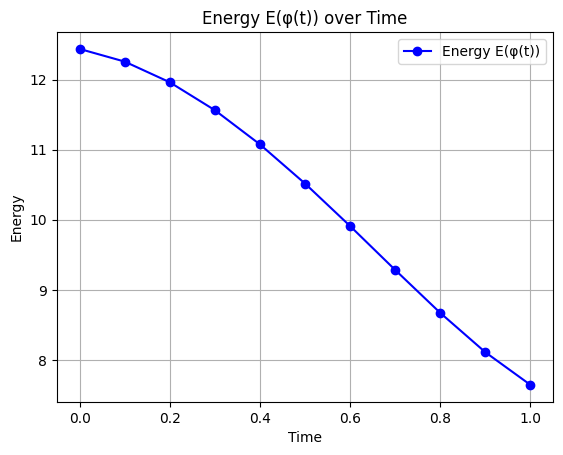

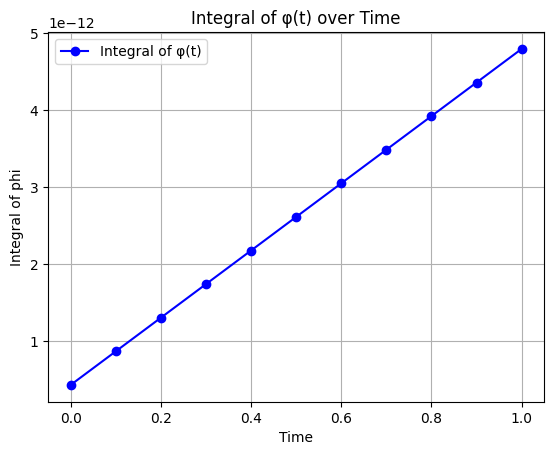

In [61]:
import matplotlib.pyplot as plt

time = [i * tau for i in range(len(energy))]


# Plot the energy data
plt.plot(time, energy, marker='o', color='b', label='Energy E(φ(t))')
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy E(φ(t)) over Time")
plt.legend()
plt.grid()
plt.show()


# Plot the integral data
plt.plot(time, integral, marker='o', color='b', label='Integral of φ(t)')
plt.xlabel("Time")
plt.ylabel("Integral of phi")
plt.title("Integral of φ(t) over Time")
plt.legend()
plt.grid()
plt.show()